# Not Too Crazy Cap Table Math
- Author: James Behzadi (Co-founder of [kintell.com](https://kintell.com/advisors/james-behzadi/not-too-crazy-cap-table-math))
- To understand the code, I recommend watching this video first (link [here](https://youtu.be/Dk6JNTDec9I)).
- This code handles up to six Safes. It also scales to as many Safes you need. If you found a bug :) or needed some help with the code, get in touch [here](https://kintell.com/advisors/james-behzadi/not-too-crazy-cap-table-math).
- To test the code I have included two examples from Y Combinator's Safe User Guide document (link [here](https://www.ycombinator.com/documents/)).

## Disclaimer:
- I am not taking any responsibility for you using this. I only share this with an educational mindset on an 'as it is' basis to help founders to get their head around cap table math.

### Conversion at SAFE Price
Example 1 (item 2) of Appendix II of YC SAFE User Guide (page 18, link [here](https://www.ycombinator.com/documents/))

- 10m shares prior to Safes with 750k in the pool (allocated and promissed)
- Investor A: 200k @ 4m Safe cap, no pro rata
- Investor B: 800k @ 8m Safe cap, yes pro rata
- Series A: 5m @ 15m pre-money with 10% increase to the ESOP
- Both SAFEs convert at Safe price as the post-money valuation is far enough from the SAFE caps

Series Seed price per share ($) =  1.11447302068
Company Capitalisation (fully-diluted) =  17945701.3575
Founders % Reduction =  48.4556227937
Total Safe Raise =  1000000.0
Total Pre-seed Raise =  1000000.0


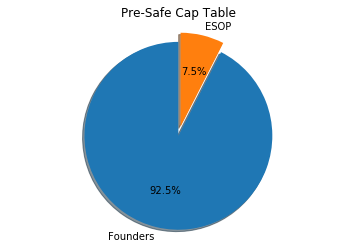

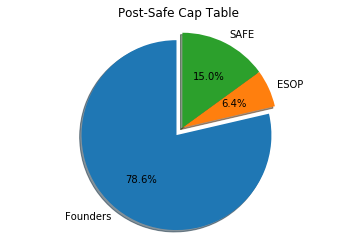

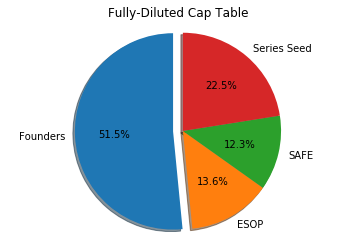

,Entity,Raise,Valuation,Discount %,Pre-SAFE %,Post-SAFE %,SAFE Shares,Conversion,Pro Rata,Final Shares,Fully-Diluted %
0,Safe A,200000,4e+06,0,0.0,5.000,5.882353e+05,Safe price,0,5.882353e+05,3.277862
1,Safe B,800000,8e+06,0,0.0,10.000,1.176471e+06,Safe price,500000,1.625113e+06,9.055724
2,Safe C,0,0,0,0.0,0.000,0.000000e+00,-,0,0.000000e+00,0.000000
3,Safe D,0,0,0,0.0,0.000,0.000000e+00,-,0,0.000000e+00,0.000000
4,Safe E,0,0,0,0.0,0.000,0.000000e+00,-,0,0.000000e+00,0.000000
5,Safe F,0,0,0,0.0,0.000,0.000000e+00,-,0,0.000000e+00,0.000000
6,Series Seed,4500000,2e+07,-,0.0,0.000,0.000000e+00,-,-,4.037783e+06,22.500000
7,Early Hires,-,-,-,6.5,5.525,6.500000e+05,-,-,6.500000e+05,3.622037
8,Options Available,-,-,-,1.0,0.850,1.000000e+05,-,-,1.794570e+06,10.000000
9,Founders,-,-,-,92.5,78.625,9.250000e+06,-,-,9.250000e+06,51.544377


In [2]:
# Model inputs
safeRaise = [200e3, 800e3, 0, 0, 0, 0]
safeCap = [4e6, 8e6, 0, 0, 0, 0]
safeDiscountPer100 = [0, 0, 0, 0, 0, 0]
safeProRata = [False, True, False, False, False, False]
safeTotalProRata = [0, 0, 0, 0, 0, 0]
safeData = [safeRaise, safeCap, safeDiscountPer100, safeProRata, safeTotalProRata]

dic = {
    'raiseA' : 5e6,
    'preM' : 15e6,
    'newEsopPer100' : 10,
    'earlyHiresPer100' : 6.5,
    'preSafeShares' : 10e6,
    'preSafeESOP' : 100e3,  # promised options
    'debtRaise' : 0,
    'safeData' : safeData
}

capTable, df, _ = capTableMath(dic, True); df

### Conversion at higer price
Example 1 (item 5) of Appendix II (page 21, link [here](https://www.ycombinator.com/documents/))

- Series Seed: 2.2m @ 8.8m pre-money with 10% increase to the ESOP
- Post-money valuation of the priced round is too close to one of the safe caps
- One of the SAFEs converts at the Safe price and the other one at Seed round price per share

Series Seed price per share ($) =  0.657879977566
Company Capitalisation (fully-diluted) =  16720375.1066
Founders % Reduction =  44.6782746138
Total Safe Raise =  1000000.0
Total Pre-seed Raise =  1000000.0


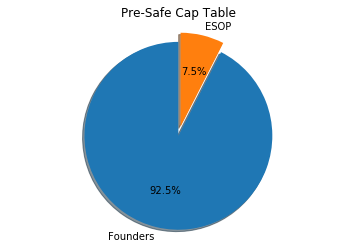

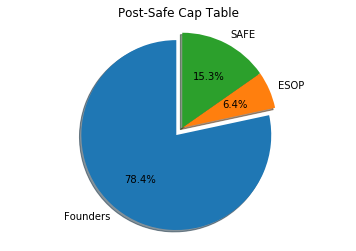

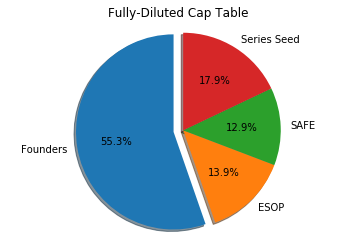

,Entity,Raise,Valuation,Discount %,Pre-SAFE %,Post-SAFE %,SAFE Shares,Conversion,Pro Rata,Final Shares,Fully-Diluted %
0,Safe A,200000,4e+06,0,0.0,4.983245,5.882353e+05,Safe price,0,5.882353e+05,3.518075
1,Safe B,800000,8e+06,0,0.0,10.301595,1.216027e+06,Seed price,226635,1.560520e+06,9.333046
2,Safe C,0,0,0,0.0,0.000000,0.000000e+00,-,0,0.000000e+00,0.000000
3,Safe D,0,0,0,0.0,0.000000,0.000000e+00,-,0,0.000000e+00,0.000000
4,Safe E,0,0,0,0.0,0.000000,0.000000e+00,-,0,0.000000e+00,0.000000
5,Safe F,0,0,0,0.0,0.000000,0.000000e+00,-,0,0.000000e+00,0.000000
6,Series Seed,1.97336e+06,1.1e+07,-,0.0,0.000000,0.000000e+00,-,-,2.999582e+06,17.939681
7,Early Hires,-,-,-,6.5,5.506485,6.500000e+05,-,-,6.500000e+05,3.887473
8,Options Available,-,-,-,1.0,0.847152,1.000000e+05,-,-,1.672038e+06,10.000000
9,Founders,-,-,-,92.5,78.361524,9.250000e+06,-,-,9.250000e+06,55.321725


In [3]:
dic['raiseA'] = 2.2e6; dic['preM'] = 8.8e6
_, df, _ = capTableMath(dic, True); df

## Some boring functions to do the math & graphs
- First run the following cell and then the ones at the top :)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import numpy as np
from scipy.optimize import fsolve

def capTableMath(dic, verbose):
    
    # update computed values
    computedVals(dic)
    
    # iterative calculation of Series Seed price per share
    data = dic['raiseA'], dic['postM'], dic['esopVal'], dic['preSafeESOP'], dic['preSafeShares'], dic['safeData'], False
    tmp = fsolve(f, .8, args=data)
    sAprice = tmp[0]
    
    # Now do the calculations one last time to get the final shares
    data = dic['raiseA'], dic['postM'], dic['esopVal'], dic['preSafeESOP'], dic['preSafeShares'], dic['safeData'], True
    _, df, finalCap, safeSharesTot, esopShares = f(sAprice, *data)
    
    # some var defs
    safeRaise, _, _, _, _ = dic['safeData']
    nSafes = len(safeRaise)
    preSafeCap = dic['preSafeShares']
    postSafeCap = preSafeCap + safeSharesTot
    a4 = dic['earlyHiresShares']
    a5a = dic['preSafeESOP']; a5b = esopShares
    a6 = dic['foundersShares']
    df.loc[df.Entity == 'Series Seed', 'Raise'] = sAprice * df.loc[df.Entity == 'Series Seed', 'Final Shares']
    df.loc[df.Entity == 'Series Seed', 'Valuation'] = dic['postM']
    df.loc[nSafes+1] = ['Early Hires', '-', '-', '-', a4/preSafeCap*100, a4/postSafeCap*100, 
                        a4, '-', '-', a4, a4/finalCap*100]
    df.loc[nSafes+2] = ['Options Available', '-', '-', '-', a5a/preSafeCap*100, a5a/postSafeCap*100, 
                        a5a, '-', '-', a5b, a5b/finalCap*100]
    df.loc[nSafes+3] = ['Founders', '-', '-', '-', a6/preSafeCap*100, a6/postSafeCap*100, 
                        a6, '-', '-', a6, a6/finalCap*100]
    df.loc[nSafes+4] = ['Total', 
                        sum(df['Raise'].iloc[0:nSafes+1]),
                        '-', '-', sum(df['Pre-SAFE %'].iloc[0:nSafes+4]), \
                        sum(df['Post-SAFE %'].iloc[0:nSafes+4]), 
                        sum(df['SAFE Shares'].iloc[0:nSafes+4]), '-', 
                        sum(df['Pro Rata'].iloc[0:nSafes]),
                        sum(df['Final Shares'].iloc[0:nSafes+4]), 
                        sum(df['Fully-Diluted %'].iloc[0:nSafes+4])
                       ]
    
    capTablePreSafe = capTableBuilder(df, nSafes, 'SAFE Shares', preSafeCap)
    capTablePostSafe = capTableBuilder(df, nSafes, 'SAFE Shares', postSafeCap)
    capTableSeed = capTableBuilder(df, nSafes, 'Final Shares', finalCap)
    
    foundersDilution = 100*(1 - dic['foundersShares'] / finalCap)
    if verbose:
        print('Series Seed price per share ($) = ', sAprice)
        print('Company Capitalisation (fully-diluted) = ', finalCap)
        print('Founders % Reduction = ', foundersDilution)
        print('Total Safe Raise = ', sum(safeRaise))
        print('Total Pre-seed Raise = ', sum(safeRaise)+dic['debtRaise'])

        pieChartPlotter(capTablePreSafe, 'preSafe')
        pieChartPlotter(capTablePostSafe, 'postSafe')
        pieChartPlotter(capTableSeed, 'seed')
    
    return capTableSeed, df, foundersDilution

def capTableBuilder(df, nSafes, colName, cap):
    capTable = {
        "safes" : (
            df.iloc[0][colName] + df.iloc[1][colName] + df.iloc[2][colName] +
            df.iloc[3][colName] + df.iloc[4][colName] + df.iloc[5][colName]) / cap,
        "sA" : df.iloc[nSafes][colName] / cap,
        "esop" : (df.iloc[nSafes+1][colName] + df.iloc[nSafes+2][colName]) / cap,
        "founders" : df.iloc[nSafes+3][colName] / cap
    }
    return capTable

def pieChartPlotter(capTable, roundName):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    if roundName == 'preSafe':
        labels = 'Founders', 'ESOP'
        sizes = [capTable['founders'], capTable['esop']]
        explode = (0.1, 0)
        jTitle = 'Pre-Safe Cap Table'
    elif roundName == 'postSafe':
        labels = 'Founders', 'ESOP', 'SAFE'
        sizes = [capTable['founders'], capTable['esop'], capTable['safes']]
        explode = (0.1, 0, 0)
        jTitle = 'Post-Safe Cap Table'
    elif roundName == 'seed':
        labels = 'Founders', 'ESOP', 'SAFE', 'Series Seed'
        sizes = [capTable['founders'], capTable['esop'], capTable['safes'], capTable['sA']]
        explode = (0.1, 0, 0, 0)
        jTitle = 'Fully-Diluted Cap Table'

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(jTitle)

    plt.show()
    
def computedVals(dic):
    dic['postM'] = dic['raiseA'] + dic['preM']
    dic['esopVal'] = dic['newEsopPer100']/100 * dic['postM']
    dic['foundersShares'] = (1-dic['earlyHiresPer100']/100) * dic['preSafeShares'] - dic['preSafeESOP']
    dic['earlyHiresShares'] = dic['earlyHiresPer100']/100 * dic['preSafeShares']
    return

def f(sAprice, *dataIn):
    raiseA, postM, esopVal, preSafeESOP, preSafeShares, safeData, dfYes = dataIn  # automatic unpacking
    
    df, safeSharesTot = safeCalcs(sAprice, preSafeShares, *safeData)
    
    postSafeCap = preSafeShares + safeSharesTot
    sAshares = raiseA / sAprice
    esopShares = esopVal / sAprice
    finalCap = postSafeCap + (esopShares - preSafeESOP) + sAshares
    
    # pro rata calcs
    df = proRataCalcs(sAprice, df, sAshares, finalCap, *safeData)
        
    expectedSeriesAper100 = raiseA / postM
    trueSeriesAper100 = sAshares / finalCap
    dif = trueSeriesAper100 - expectedSeriesAper100
    
    if dfYes:
        out = dif, df, finalCap, safeSharesTot, esopShares
    else:
        out = dif

    return out

def safeCalcs(sAprice, preSafeShares, *safeData):
    safeRaise, safeCap, safeDiscountPer100, safeProRata, safeTotalProRata = safeData
        
    expectedSafePer100Tot = 0; expectedSafePer100 = []
    discountSharesTot = 0; discountShares = []
    for i in range(len(safeRaise)):
        expectedSafePer100.append(0)
        discountShares.append(0)
        if safeCap[i] > 0:     # SAFEs with valuation cap
            expectedSafePer100[i] = safeRaise[i] / safeCap[i] * 100
        else:                  # SAFEs with discount only
            discountShares[i] = safeRaise[i] / (sAprice * (1-safeDiscountPer100[i]/100))
        expectedSafePer100Tot = expectedSafePer100Tot + expectedSafePer100[i]
        discountSharesTot = discountSharesTot + discountShares[i]
    
    postSafeSharesTmp = (preSafeShares + discountSharesTot) / (1 - expectedSafePer100Tot/100)
    
    safeShares = []; convMethod = []
    for i in range(len(safeRaise)):
        safeShares.append(0); convMethod.append(' ')
        if safeCap[i] > 0:     # SAFEs with valuation cap
            convMethod[i], safeShares[i] = getSafeMethod(sAprice, safeCap[i], safeRaise[i], 
                                                         safeDiscountPer100[i], postSafeSharesTmp)
        else:                  # SAFEs with discount only
            safeShares[i] = discountShares[i]
            if safeDiscountPer100[i] == 0:
                convMethod[i] = '-'
            else:
                convMethod[i] = 'Discount only'
    
    # accounting for conversion at non-safe price
    nonSafePriceSahres = 0
    for i in range(len(safeRaise)):
        if convMethod[i] == 'S-A price':
            nonSafePriceSahres = nonSafePriceSahres + safeShares[i]
    if nonSafePriceSahres > 0:
        for i in range(len(safeRaise)):
            if convMethod[i] == 'Safe price':
                safeShares[i] = (preSafeShares + discountSharesTot + nonSafePriceSahres) * \
                expectedSafePer100[i]/100 / (1 - expectedSafePer100[i]/100)
    
    # summing it all up
    safeSharesTot = 0
    for i in range(len(safeRaise)):
        safeSharesTot = safeSharesTot + safeShares[i]
    postSafeShares = preSafeShares + safeSharesTot
        
    df = pd.DataFrame(OrderedDict((
        ('Entity', ['Safe A', 'Safe B', 'Safe C', 'Safe D', 'Safe E', 'Safe F']),
        ('Raise', [safeRaise[0], safeRaise[1], safeRaise[2], safeRaise[3], safeRaise[4], safeRaise[5]]),
        ('Valuation', [safeCap[0], safeCap[1], safeCap[2], safeCap[3], safeCap[4], safeCap[5]]),
        ('Discount %', [safeDiscountPer100[0], safeDiscountPer100[1], safeDiscountPer100[2], 
                        safeDiscountPer100[3], safeDiscountPer100[4], safeDiscountPer100[5]]),
        ('Pre-SAFE %', [0, 0, 0, 0, 0, 0]),
        ('Post-SAFE %', [safeShares[0]/postSafeShares*100, safeShares[1]/postSafeShares*100, 
                         safeShares[2]/postSafeShares*100, safeShares[3]/postSafeShares*100, 
                         safeShares[4]/postSafeShares*100, safeShares[5]/postSafeShares*100]),
        ('SAFE Shares', [safeShares[0], safeShares[1], safeShares[2], safeShares[3], safeShares[4], 
                         safeShares[5]]),
        ('Conversion', [convMethod[0], convMethod[1], convMethod[2], convMethod[3], convMethod[4], 
                        convMethod[5]]),
        ('Pro Rata', [safeProRata[0], safeProRata[1], safeProRata[2], safeProRata[3], safeProRata[4], 
                      safeProRata[5]])
        )))
    return df, safeSharesTot

def getSafeMethod(
    sAprice, safeCap, safeRaise, safeDiscountPer100, postSafeSharesTmp
):
    shareMethod1 = safeRaise / safeCap * postSafeSharesTmp
    shareMethod2 = safeRaise / (sAprice * (1-safeDiscountPer100/100))

    if shareMethod1 > shareMethod2:
        convMethod = 'Safe price'
        safeShares = shareMethod1
    else:
        convMethod = 'Seed price'
        safeShares = shareMethod2
    
    return convMethod, safeShares     

def proRataCalcs(sAprice, df, sAsharesTot, finalCap, *safeData):
    
    safeRaise, safeCap, safeDiscountPer100, safeProRata, safeTotalProRata = safeData
    
    sAshares = []
    proRataSharesTot = 0
    for i in range(len(safeRaise)):
        sAshares.append(0)
        postSAFEper100 = df.iloc[i]['Post-SAFE %']
        safeShares = df.iloc[i]['SAFE Shares']
        if safeProRata[i]:
            proRataShares = postSAFEper100/100 * sAsharesTot
            if safeTotalProRata[i] > 0:
                proRataShares_tmp = safeTotalProRata[i] / (sAprice * (1-safeDiscountPer100[i]/100))
                proRataShares = max(proRataShares, proRataShares_tmp)
            df.loc[df.Entity == df.iloc[i]['Entity'], 'Pro Rata'] = proRataShares * sAprice * (1-safeDiscountPer100[i]/100)
        else:
            proRataShares = 0
        sAshares[i] = safeShares + proRataShares
        proRataSharesTot = proRataSharesTot + proRataShares
    
    sAshares_seed = sAsharesTot - proRataSharesTot

    df.loc[len(safeRaise)] = ['Series Seed', '-', '-', '-', 0, 0, 0, '-', '-']
    df['Final Shares'] = [sAshares[0], sAshares[1], sAshares[2], sAshares[3], sAshares[4], sAshares[5], 
                          sAshares_seed]
    df['Fully-Diluted %'] = [sAshares[0]/finalCap*100, sAshares[1]/finalCap*100, sAshares[2]/finalCap*100, 
                             sAshares[3]/finalCap*100, sAshares[4]/finalCap*100, sAshares[5]/finalCap*100, 
                             sAshares_seed/finalCap*100]
    
    return df


def valuationSensitivity(dic, raiseA, newEsopPer100, title):
    dic['raiseA'] = raiseA
    dic['newEsopPer100'] = newEsopPer100
    founders = []; sA = []; postM = []; foundersDilution = []
    x = range(10, 20)
    for preM in x:
        dic['preM'] = preM * 1e6
        capTable, _, temp = capTableMath(dic, False)
        founders.append(capTable['founders']*100)
        sA.append(capTable['sA']*100)
        postM.append(dic['postM']/1e6)
        foundersDilution.append(temp)

    # data
    df = pd.DataFrame(OrderedDict(
        (('post-money', postM), ('% founders', founders), ('% series-Seed', sA), ('% reduction', foundersDilution))))
    plotter(df, 'post-money', 'Post Money Valuation (milion $)', title)

    return df

def raiseSensitivity(dic, preM, newEsopPer100, title):
    dic['preM'] = preM
    dic['newEsopPer100'] = newEsopPer100
    founders = []; sA = []; raiseA = []; foundersDilution = []
    x = np.arange(2.5, 5.2, .25)
    for raiseA in x:
        dic['raiseA'] = raiseA * 1e6
        capTable, _, temp = capTableMath(dic, False)
        founders.append(capTable['founders']*100)
        sA.append(capTable['sA']*100)
        foundersDilution.append(temp)

    # data
    df = pd.DataFrame({'Seed Raise': x, '% founders': founders, '% series-Seed': sA, '% reduction' : foundersDilution})
    plotter(df, 'Seed Raise', 'Series Seed raise (milion $)', title)

    return df

def plotter(df, x, xlabel, title):
    # multiple line plot
    plt.plot( x, '% founders', data=df, marker='o', markerfacecolor='yellow', markersize=12, color='blue', linewidth=4)
    plt.plot( x, '% series-Seed', data=df, marker='o', markerfacecolor='skyblue', markersize=12, color='pink', linewidth=4)
#     plt.plot( x, '% reduction', data=df, marker='o', markerfacecolor='grey', markersize=12, color='lightgrey', linewidth=4)
    plt.legend(loc='center right')
    plt.grid(b=True, which='major', color='grey', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel('%')
    plt.title(title)
    plt.show()
    return

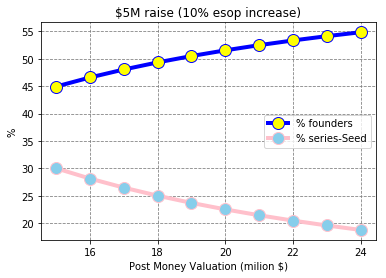

,post-money,% founders,% series-Seed,% reduction
0,15.0,44.936124,30.000000,55.063876
1,16.0,46.588187,28.125000,53.411813
2,17.0,48.045890,26.470588,51.954110
3,18.0,49.341626,25.000000,50.658374
4,19.0,50.500969,23.684211,49.499031
5,20.0,51.544377,22.500000,48.455623
6,21.0,52.488413,21.428571,47.511587
7,22.0,53.346628,20.454545,46.653372
8,23.0,54.130216,19.565217,45.869784
9,24.0,54.848504,18.750000,45.151496


In [4]:
df = valuationSensitivity(dic, 5e6, 10, '$5M raise (10% esop increase)'); df

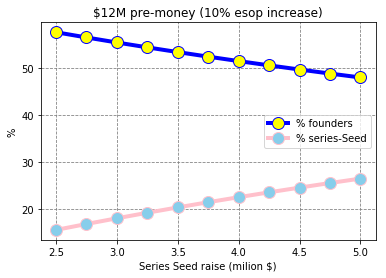

,Seed Raise,% founders,% series-Seed,% reduction
0,2.50,57.696889,15.517241,42.303111
1,2.75,56.584571,16.779661,43.415429
2,3.00,55.509329,18.000000,44.490671
3,3.25,54.469342,19.180328,45.530658
4,3.50,53.462902,20.322581,46.537098
5,3.75,52.488413,21.428571,47.511587
6,4.00,51.544377,22.500000,48.455623
7,4.25,50.629388,23.538462,49.370612
8,4.50,49.742126,24.545455,50.257874
9,4.75,48.881350,25.522388,51.118650


In [5]:
raiseSensitivity(dic, 12e6, 10, '$12M pre-money (10% esop increase)')